#  Predicting Instagram Like Counts

#### By: Josh Blas

#### Background
The primary goal of this analysis is to build a model that uses Instagram characteristics to predict the number of likes that an Instagram post will receive. This project was inspired by https://towardsdatascience.com/predict-the-number-of-likes-on-instagram-a7ec5c020203. 

Similar to other social media platforms, Instagram allows its users to "like" photos and videos that appear on their feed. The number of likes on a post is typically a measure of its popularity and/or quality. Brands and social media marketers want their posts to have high engagement and audience interaction, and like counts provide a metric for them to quantify their content's reception.

#### Dataset

The dataset used in this analysis was obtained from https://github.com/gvsi and contains analytics for 2000+ Instagram influencers. The original dataset had 30,000 observations on Instagram posts ranging from March 27, 2016 to May 2, 2017. The dataset includes several post attributes such as account username, post date and time, number of followers and following, and the number of likes and comments. We will explore how these different features are associated with the number of likes a post receives.

#### Imports

We first load all the necessary packages for the analysis.

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import sklearn
%matplotlib inline
from sklearn import metrics
from sklearn import model_selection
from sklearn import tree
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
plt.style.use('fivethirtyeight')

#### Data Cleaning





Here we import the dataset which was stored as an excel workbook. We then clean the data so that we can conduct some exploratory analysis.

In [208]:
# Reading in data and getting rid on unwanted columns
df = pd.read_excel("data_insta.xlsx")
df = df.drop(df.columns[list(np.arange(14,40))], axis=1)
df = df.drop(["USERNAME","LINK","LOCATION"], axis=1)
df = df.dropna()

# Changing uppercase column names with spaces to 
# lowercase column names with underscores
newcol = {"number of tags" : "num_tags",
          "list of tags": "list_of_tags",
          "text":"caption",
          "day(0 monday,6 sunday)": "day_of_week",
          "type(1 photo,2 video)": "type_of_post",
          "users in photo": "num_users"}
df.columns = df.columns.str.lower()
df = df.rename(columns=newcol)

# Changing string dates to datetime objects
def is_valid_date(x):
    if isinstance(x, datetime.date):
        return True
    else:
        return False
    
df = df[df["date"].apply(is_valid_date)]
df.loc[:,"date"] = pd.to_datetime(df.loc[:,"date"])
df = df[df["num_tags"] != "-"]
df["num_tags"] = df["num_tags"].astype(int)
df["num_users"] = df["num_users"].astype(int)
df["day_of_week"] = df["day_of_week"].astype(int)
df["type_of_post"] = df["type_of_post"].astype(int)

# Translating numerically coded weekdays 
def num_to_weekday(x):
    if x == 0:
        return "monday"
    elif x == 1:
        return "tuesday"
    elif x == 2:
        return "wednesday"
    elif x == 3:
        return "thursday"
    elif x == 4:
        return "friday"
    elif x == 5:
        return "saturday"
    elif x == 6:
        return "sunday"
    
df["day_of_week"] = df["day_of_week"].apply(num_to_weekday)
df["type_of_post"] = df["type_of_post"].astype("category")
df["day_of_week"] = df["day_of_week"].astype("category")

# Extracting month and hour from dt object into separate categorical columns
def extract_month(x):
    return x.strftime('%B')
def extract_hour(x):
    return x.hour

df["month"] = df["date"].apply(extract_month)
df["hour"] = df["date"].apply(extract_hour)
df["month"] = df["month"].astype("category")
df["hour"] = df["hour"].astype("category")

# Creating a new column for caption length 
def caption_length(x):
    return len(x)

df["caption_length"] = df["caption"].apply(caption_length)

# Removing column with captions
df = df.drop(["caption"], axis=1)

# Translating numerically coded media type into strings
def num_to_media(x):
    if x == 1:
        return "photo"
    if x == 2:
        return "video"
     
df["type_of_post"] = df["type_of_post"].apply(num_to_media)
df["type_of_post"] = df["type_of_post"].astype("category")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7902 entries, 0 to 11537
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   followers       7902 non-null   int64         
 1   following       7902 non-null   int64         
 2   likes           7902 non-null   int64         
 3   comments        7902 non-null   int64         
 4   num_tags        7902 non-null   int64         
 5   list_of_tags    7902 non-null   object        
 6   date            7902 non-null   datetime64[ns]
 7   day_of_week     7902 non-null   category      
 8   type_of_post    7902 non-null   category      
 9   num_users       7902 non-null   int64         
 10  month           7902 non-null   category      
 11  hour            7902 non-null   category      
 12  caption_length  7902 non-null   int64         
dtypes: category(4), datetime64[ns](1), int64(7), object(1)
memory usage: 649.8+ KB


,followers,following,likes,comments,num_tags,list_of_tags,date,day_of_week,type_of_post,num_users,month,hour,caption_length
0,1134619,915,18560,95,2,#newera#newday,2017-02-11 11:05:10.000000,saturday,photo,1,February,11,56
1,1134619,915,17710,86,3,#goodnight#goodone#weekend,2017-02-11 00:33:09.999999,saturday,photo,1,February,0,64
2,1134619,915,11959,79,7,#tb#memories#greece#stous31dromous#newyork#200...,2017-02-09 15:51:47.000005,thursday,photo,3,February,15,60
3,1134619,915,13608,37,2,#mprousko4#filming,2017-02-08 18:21:57.000004,wednesday,photo,3,February,18,103
4,1134619,915,15842,62,4,#peru#lifelessons#tb#andreasgeorgiou✔️,2017-02-08 13:03:13.999997,wednesday,photo,0,February,13,91


#### Visualizing Quantitative Predictor Distributions

Here we plot histograms for each quantitative predictor variable so that we can visualize their univariate distributions.

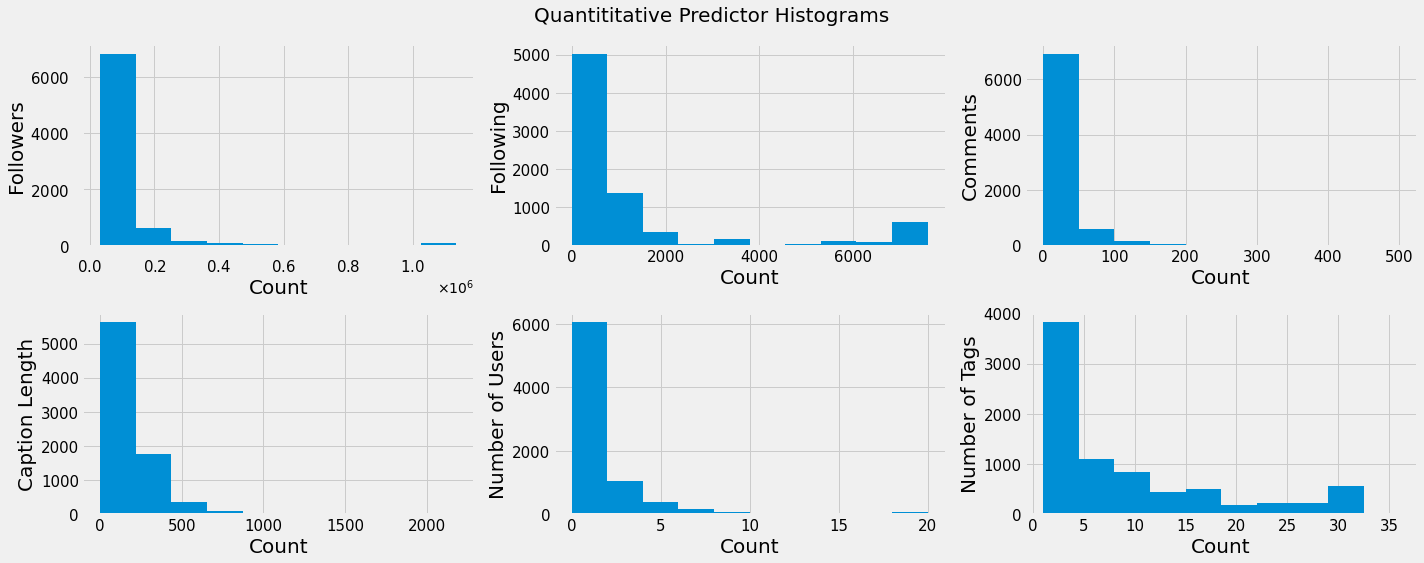

In [400]:
# Plotting all the histogram subplots
fig, axes = plt.subplots(2, 3, figsize=(20,8))

# Creating Followers Histogram
axes[0, 0].hist(df["followers"],rwidth=5)
axes[0, 0].set_xlabel('Count', fontsize=20)
axes[0, 0].set_ylabel('Followers', fontsize=20)
axes[0, 0].tick_params(axis='both', labelsize=15, pad=13)
axes[0, 0].ticklabel_format(useMathText=True)

# Creating Following Histogram
axes[0, 1].hist(df["following"])
axes[0, 1].set_xlabel('Count', fontsize=20)
axes[0, 1].set_ylabel('Following', fontsize=20)
axes[0, 1].tick_params(axis='both', labelsize=15)

# Creating Comments Histogram
axes[0, 2].hist(df["comments"])  
axes[0, 2].set_xlabel('Count', fontsize=20)
axes[0, 2].set_ylabel('Comments', fontsize=20)
axes[0, 2].tick_params(axis='both', labelsize=15)

# Creating Caption Length Histogram
axes[1, 0].hist(df["caption_length"])
axes[1, 0].set_xlabel('Count', fontsize=20)
axes[1, 0].set_ylabel('Caption Length', fontsize=20)
axes[1, 0].tick_params(axis='both', labelsize=15)

# Creating Number of Users Histogram
axes[1, 1].hist(df["num_users"])
axes[1, 1].set_xlabel('Count', fontsize=20)
axes[1, 1].set_ylabel('Number of Users', fontsize=20)
axes[1, 1].tick_params(axis='both', labelsize=15)

# Creating Number of Tags Histogram
axes[1, 2].hist(df["num_tags"])
axes[1, 2].set_xlabel('Count', fontsize=20)
axes[1, 2].set_ylabel('Number of Tags', fontsize=20)
axes[1, 2].tick_params(axis='both', labelsize=15)

fig.suptitle("Quantititative Predictor Histograms", fontsize=20)
plt.tight_layout()
plt.show()

We can see that all of the quantitative predictor distributions are unimodal and right-tailed.

#### Visualizing Average Likes for Categorical Variables

Here we plot bar charts for the categorical variables so that we can see how average likes is distributed across different levels. 

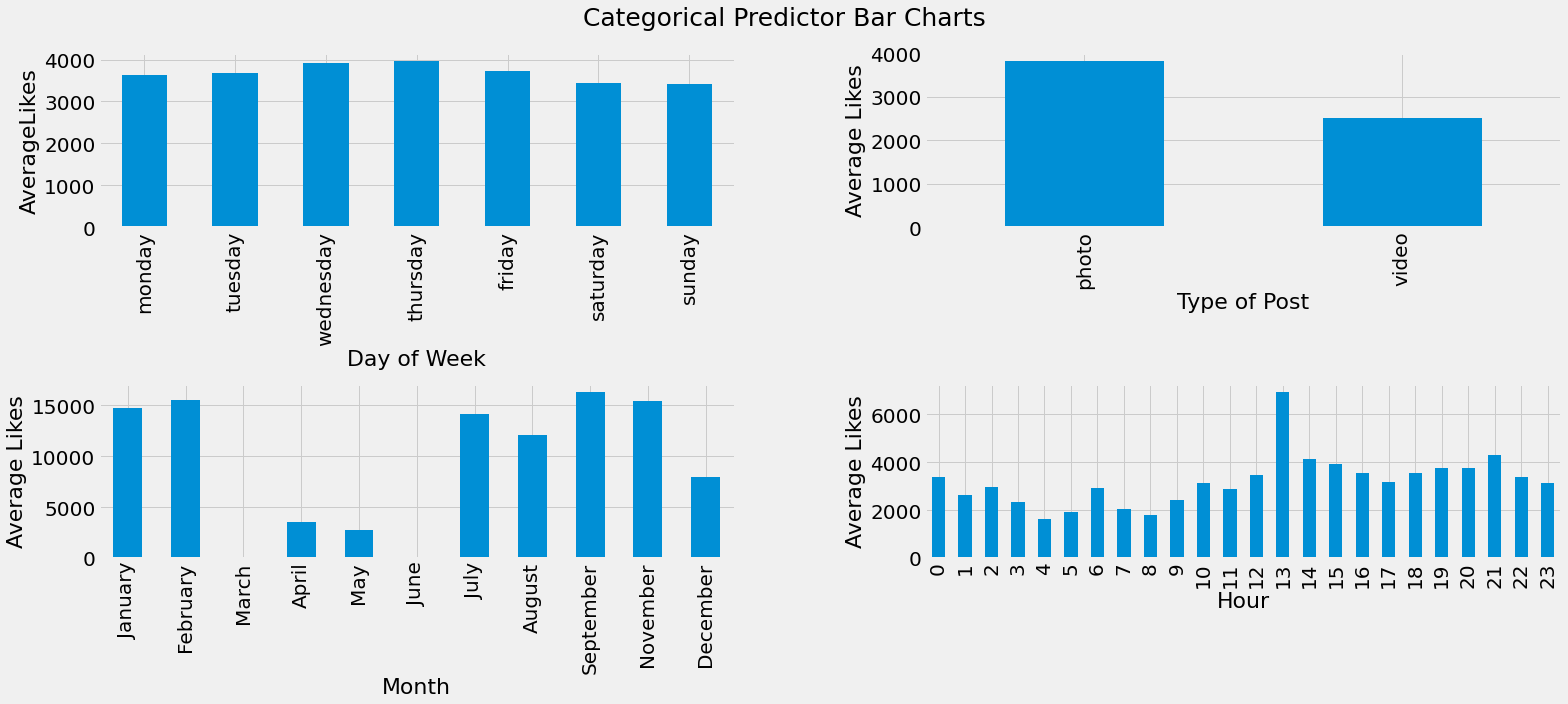

In [442]:
# Grouping by different categorical predictors and finding averages

# Like averages grouped by weekday
gb_day = df.groupby("day_of_week")
gb_day_avg = gb_day.mean().reindex(["monday","tuesday","wednesday","thursday",
                      "friday","saturday","sunday"]).reset_index()

# Like averages grouped by post type
gb_media = df.groupby("type_of_post")
gb_media_avg = gb_media.mean().reset_index()

# Like averages grouped by month
gb_month = df.groupby("month")
gb_month_avg = gb_month.mean().reindex(["January","February","March",
                                        "April", "May", "June", "July",
                                        "August", "September",
                                        "November", "December"]
                                      ).reset_index()
# Like averages grouped by hour
gb_hour = df.groupby("hour")
gb_hour_avg = gb_hour.mean().reset_index()

# Plotting all the bar subplots for average likes vs categorical predictor
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22,10))

# Creating Avg Likes vs Day of Week bar chart 
gb_day_avg.plot(x = "day_of_week", y = "likes", kind = "bar", ax=axes[0,0],
                legend=False, fontsize=20)
axes[0,0].set_xlabel("Day of Week", fontsize=22)
axes[0,0].set_ylabel("AverageLikes", fontsize=22)

# Creating Avg Likes vs Type of Post bar chart 
gb_media_avg.plot(x = "type_of_post", y = "likes", kind = "bar", ax=axes[0,1],
                  legend=False, fontsize=20)
axes[0,1].set_xlabel("Type of Post", fontsize=22)
axes[0,1].set_ylabel("Average Likes", fontsize=22)

# Creating Avg Likes vs Month bar chart  
gb_month_avg.plot(x = "month", y = "likes", kind = "bar", ax=axes[1,0],
                  legend=False,  fontsize=20)
axes[1,0].set_xlabel("Month", fontsize=22)
axes[1,0].set_ylabel("Average Likes", fontsize=22)

# Creating Avg Likes vs Hour bar chart 
gb_hour_avg.plot(x = "hour", y = "likes", kind = "bar", ax=axes[1,1],
                 legend=False, fontsize=20)
axes[1,1].set_xlabel("Hour", fontsize=22)
axes[1,1].set_ylabel("Average Likes", fontsize=22)

fig.suptitle("Categorical Predictor Bar Charts", fontsize=25)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

We can see in the top-left plot that average likes is spread fairly evenly across days of the week at around 3500-3900 likes.

The top-right plot shows that on average, photos get approximately 1000 more likes than videos get.

The bottom-left plot does show some variability in likes between the months, though it should be noted that the months were not equally sampled in the dataset. There were also no observations for the months of March and June in the dataset.

The bottom-right plot shows that there is quite a bit of variability among the hours, though posts at the 13th hour (1:00 PM) seem to be receiving the most average likes. 

#### Visualizing Most Liked Hashtags

Here we plot the top 10 hashtags ranked by total likes. 

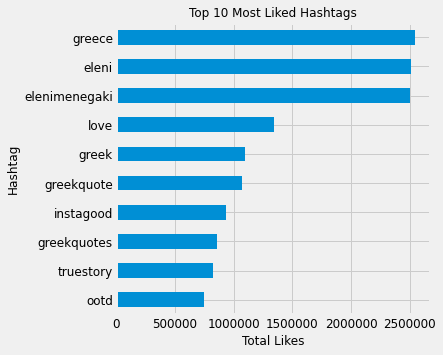

In [484]:
# Extracting list of hashtags from list_of_tags column
def string_to_los(s):
    los = s.split("#")
    return los[1:]

tag_df = df.loc[:,["likes", "list_of_tags"]]
tag_df["list_of_tags"] = tag_df["list_of_tags"].apply(string_to_los)
tag_list = tag_df.to_dict(orient="records")

# Creating dictionary with individual hashtags as keys and total likes as values
dicty = {}
for d in tag_list:
    numlikes = d["likes"]
    for t in d["list_of_tags"]:
        if t in dicty.keys():
            dicty[t] += numlikes
        else:
            dicty[t] = numlikes 

# Converting dictionary to dataframe and sorting
tags_clean = pd.DataFrame(data=dicty.values(), index=dicty.keys()) 
tags_clean = tags_clean.rename(columns={0:"total_likes"})
tags_clean = tags_clean.sort_values(by="total_likes", ascending=True)

# Plotting top 25 most liked hashtags
tag_top_10 = tags_clean[-10:]
tag_top_10_plot = tag_top_10.plot(kind="barh", legend=False, fontsize=12, figsize=(5,5))
tag_top_10_plot.set_xlabel("Total Likes", fontsize=12)
tag_top_10_plot.set_ylabel("Hashtag", fontsize=12)
tag_top_10_plot.set_title('Top 10 Most Liked Hashtags', fontsize=12)
tag_top_10_plot.ticklabel_format(style='plain', axis='x')

The top three hashtags by a considerable margin are #greece, #eleni, and #elenimenegaki. 

Based on the plot, it appears that our dataset may include several accounts associated with Greece.

#### Visualizing Quantitative Predictor Relationships with Likes

Here we plot scatterplots for quantitative predictors versus total likes.

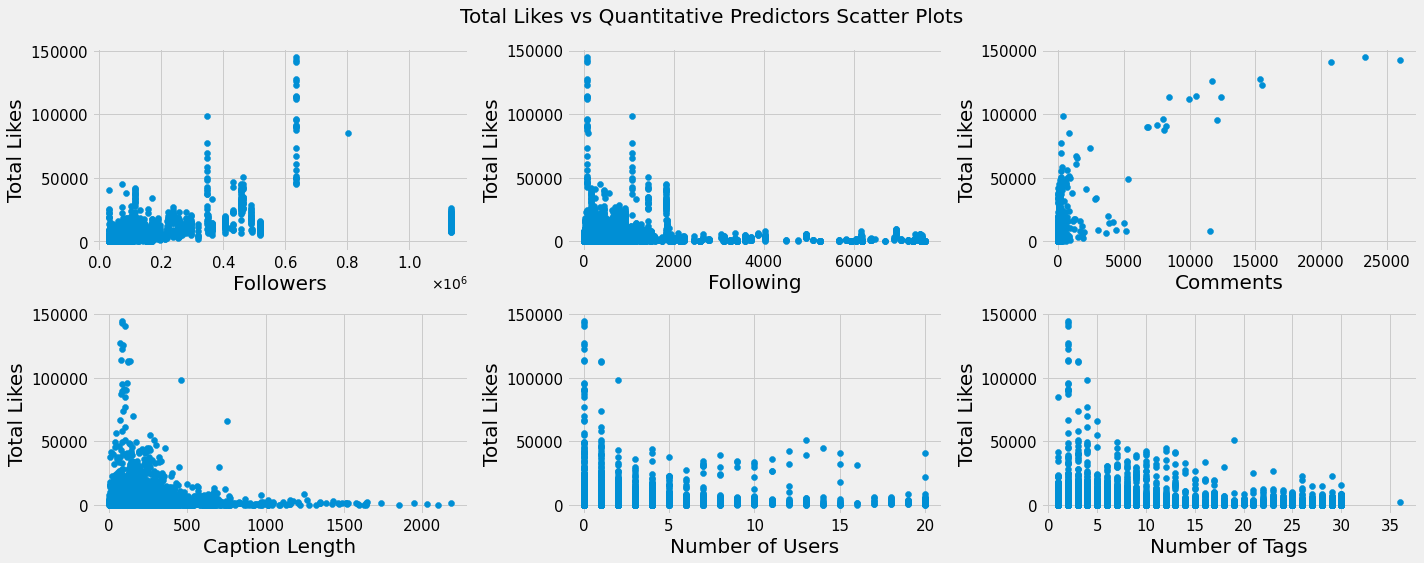

In [404]:
# Plotting all the scatterplot subplots
fig, axes = plt.subplots(2, 3, figsize=(20,8))

# Creating Total Likes vs Followers scatter plot 
axes[0, 0].scatter(df["followers"], df["likes"])
axes[0, 0].set_xlabel('Followers', fontsize=20)
axes[0, 0].set_ylabel('Total Likes', fontsize=20)
axes[0, 0].ticklabel_format(useMathText=True)
axes[0, 0].tick_params(axis='both', labelsize=15)

# Creating Total Likes vs Following scatter plot 
axes[0, 1].scatter(df["following"], df["likes"])
axes[0, 1].set_xlabel('Following', fontsize=20)
axes[0, 1].set_ylabel('Total Likes', fontsize=20)
axes[0, 1].tick_params(axis='both', labelsize=15)

# Creating Total Likes vs Comments scatter plot 
axes[0, 2].scatter(df["comments"], df["likes"])
axes[0, 2].set_xlabel('Comments', fontsize=20)
axes[0, 2].set_ylabel('Total Likes', fontsize=20)
axes[0, 2].tick_params(axis='both', labelsize=15)

# Creating Total Likes vs Caption Length scatter plot 
axes[1, 0].scatter(df["caption_length"], df["likes"])
axes[1, 0].set_xlabel('Caption Length', fontsize=20)
axes[1, 0].set_ylabel('Total Likes', fontsize=20)
axes[1, 0].tick_params(axis='both', labelsize=15)

# Creating Total Likes vs Number of Users scatter plot 
axes[1, 1].scatter(df["num_users"], df["likes"])
axes[1, 1].set_xlabel('Number of Users', fontsize=20)
axes[1, 1].set_ylabel('Total Likes', fontsize=20)
axes[1, 1].tick_params(axis='both', labelsize=15)

# Creating Total Likes vs Number of Tags scatter plot 
axes[1, 2].scatter(df["num_tags"], df["likes"])
axes[1, 2].set_xlabel('Number of Tags', fontsize=20)
axes[1, 2].set_ylabel('Total Likes', fontsize=20)
axes[1, 2].tick_params(axis='both', labelsize=15)

fig.suptitle("Total Likes vs Quantitative Predictors Scatter Plots", fontsize=20)
plt.tight_layout()

Most of the relationships appear to be non-linear. The comments and followers scatterplots suggest a positive association of those predictors with total likes. 

The caption length, following, number of users, and number of tags scatterplots suggest a negative association of those predictors with total likes. 

#### Visualizing Quantitative Predictor Correlations with Likes

Here we show the correlation values with total likes for the six quantitative predictors plotted above.

The bars are sorted top-to-bottom from the most positive correlation values to the most negative correlation values.

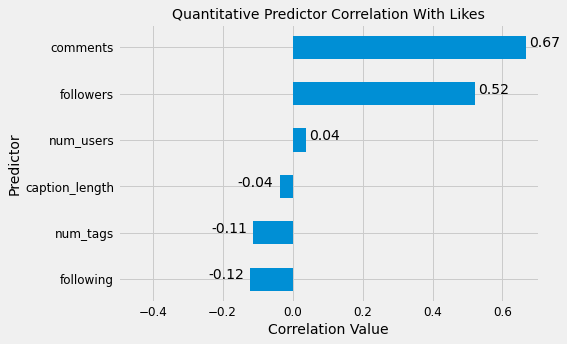

In [487]:
# Creating plot for quantitative predictor correlations with Likes
corr_df = df.corr()["likes"].sort_values().drop("likes", axis=0)
corr_plot = corr_df.plot(kind="barh", figsize=(8,5), fontsize=12, align="center")
corr_plot.set_ylabel("Predictor", fontsize=14)
corr_plot.set_xlabel("Correlation Value", fontsize=14)
corr_plot.set_title("Quantitative Predictor Correlation With Likes", fontsize=14)

# Placing value labels on bars
for a, b in enumerate(corr_df):
    if  b > 0.03:
        plt.text(b+0.009, a, str(round(b,2)), color='k', fontsize=14)
    else:
        plt.text(b-0.12, a, str(round(b,2)), color='k', fontsize=14)
        
plt.tight_layout()
corr_plot.axis(xmin=-0.5)
plt.show()

We see that comments and followers are the top two correlations by a considerable margin. This implies that they may be helpful predictor variables for building our model.

#### Creating Datasets for Model Building

Here we create the dataset to be used in the model building process. We include post type as a dummy variable.

We then create the training and testing sets with a 75/25 train-test split.

In [293]:
# Creating the dataset for models with the desired columns for analysis
df_for_regression = pd.get_dummies(df, columns=['type_of_post'], drop_first=True)
df_for_regression = df_for_regression.drop(['list_of_tags','date','day_of_week',
                                            'month','hour'], axis=1)

# Creating the training and testing sets at 75/25 splits
X = df_for_regression.drop(['likes'], axis=1)
y = df_for_regression.likes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

df_for_regression.describe()

,followers,following,likes,comments,num_tags,num_users,caption_length,type_of_post_video
count,7.902000e+03,7902.000000,7902.000000,7902.000000,7902.000000,7902.000000,7902.000000,7902.000000
mean,9.658247e+04,1339.235637,3679.122121,60.796507,8.777651,1.299798,184.041129,0.107568
std,1.458876e+05,2142.549825,7683.438715,670.701079,8.867575,2.679165,180.242795,0.309853
min,3.255200e+04,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000
25%,4.072300e+04,160.000000,701.000000,2.000000,2.000000,0.000000,68.000000,0.000000
50%,5.668900e+04,476.000000,1627.000000,7.000000,5.000000,0.000000,134.000000,0.000000
75%,9.200500e+04,1125.000000,3892.000000,23.000000,12.000000,1.000000,245.000000,0.000000
max,1.134619e+06,7586.000000,144671.000000,26011.000000,36.000000,20.000000,2181.000000,1.000000


#### Building Lasso Regression Model: Initialization and Hyperparameter Tuning

We now initialize and tune the first of three models, a Lasso Regression model. 

In [302]:
# Initializing the Lasso Regression Model
las_reg = linear_model.Lasso()

# Tuning the hyperparameters for the Lasso Model
classifier_lasso = GridSearchCV(las_reg,{
    'alpha': list(np.arange(1,6,1)),
            }, cv=10)

classifier_lasso.fit(X_train, y_train)
results_lasso = pd.DataFrame(classifier_lasso.cv_results_)
results_lasso = results_lasso[['params','mean_test_score','rank_test_score']]
top_sorted_results_lasso = results_lasso.sort_values(by="rank_test_score", axis=0)[0:1]
print(f"The best parameter in the specified range is {classifier_lasso.best_params_}")
top_sorted_results_lasso

The best parameter is {'alpha': 5}


,params,mean_test_score,rank_test_score
4,{'alpha': 5},0.579394,1


We used `GridSearchCV` to choose the hyperparameter `alpha = 5`, which is the Lasso's regularization parameter.

#### Building Lasso Regression Model: Evaluating Fitted Model's Predictions for Test Set

We now fit the Lasso model with $\alpha=5$ on the training set and use it to predict on the testing set.

In [308]:
# Fitting the Lasso Regression Model with hyperparameters from tuning
model_lasso = linear_model.Lasso(alpha=5, random_state=123)
model_lasso.fit(X_train, y_train)

# Predicting on test set and obtaining rsquared and RMSE for predictions
test_pred_lasso = model_lasso.predict(X_test)
rsquare_lasso = r2_score(y_test, test_pred_lasso)
rmse_lasso = mean_squared_error(y_test, test_pred_lasso, squared=False)
print("Lasso Regression R-squared score for the test set is", round(rsquare_lasso, 5))
print("Lasso Regression RMSE for the test set is", round(rmse_lasso, 5))

Lasso Regression R-squared score for the test set is 0.63459
Lasso Regression RMSE for the test set is 4307.67724


We then evaluated our model's predictive ability by calculating the R-squared and root-mean-square error, which produced $R^{2} = 0.64$ and $RMSE = 4307.68$.

#### Building Regression Tree Model: Initialization and Hyperparameter Tuning

We now initialize and tune the second of three models, a  Regression Tree model.

In [309]:
# Initializing the Regression Tree Model
reg_tree = tree.DecisionTreeRegressor(random_state=123)

# Tuning the hyperparameters for the Regression Tree Model
classifier_tree = GridSearchCV(reg_tree,{
    'max_depth': [5,10,15,20,25],
    'min_samples_leaf': [1,2,3,4,5],
            }, cv=10)

classifier_tree.fit(X_train, y_train)
results_tree = pd.DataFrame(classifier_tree.cv_results_)
results_tree = results_tree[['params','mean_test_score','rank_test_score']]
top_sorted_results_tree = results_tree.sort_values(by="rank_test_score", axis=0)[0:1]
print(f"The best parameters in the specified range are {classifier_tree.best_params_}")
top_sorted_results_tree

The best parameters in the specified range are {'max_depth': 10, 'min_samples_leaf': 3}


,params,mean_test_score,rank_test_score
7,"{'max_depth': 10, 'min_samples_leaf': 3}",0.767887,1


We used `GridSearchCV` to choose the hyperparameters `max_depth = 10` and `min_samples_leaf = 3`, which are the maximum depth of the tree and the minimum number of samples required to split an internal node, respectively.

#### Building Regression Tree Model: Evaluating Fitted Model's Predictions for Test Set

We now fit the Regression Tree model with `max_depth = 10` and `min_samples_leaf = 3` on the training set and use it to predict on the testing set. 

In [306]:
# Fitting the Regression Tree Model with hyperparameters from tuning
model_tree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, random_state=123)
model_tree.fit(X_train, y_train)

# Predicting on test set and obtaining rsquared and RMSE for predictions
test_pred_tree = model_tree.predict(X_test)
rsquare_tree = r2_score(y_test, test_pred_tree)
rmse_tree = mean_squared_error(y_test, test_pred_tree, squared=False)
print("Tree Regressor R-squared score for the test set is", round(rsquare_tree, 5))
print("Tree Regressor RMSE for the test set is", round(rmse_tree, 5))

Tree Regressor R-squared score for test set is 0.86918
Tree Regressor RMSE for test set is 2577.46721


We evaluated our model's predictive ability by calculating the R-squared and root-mean-square error, which produced $R^{2} = 0.87$ and $RMSE = 2577.47$. 

Both of these metrics imply that the Regression Tree model is an improvement upon the Lasso Regression model.

#### Truncated Visualization of Tree Model

Here we show a truncated version of the fitted Regression Tree model, to a maximum depth of one. 

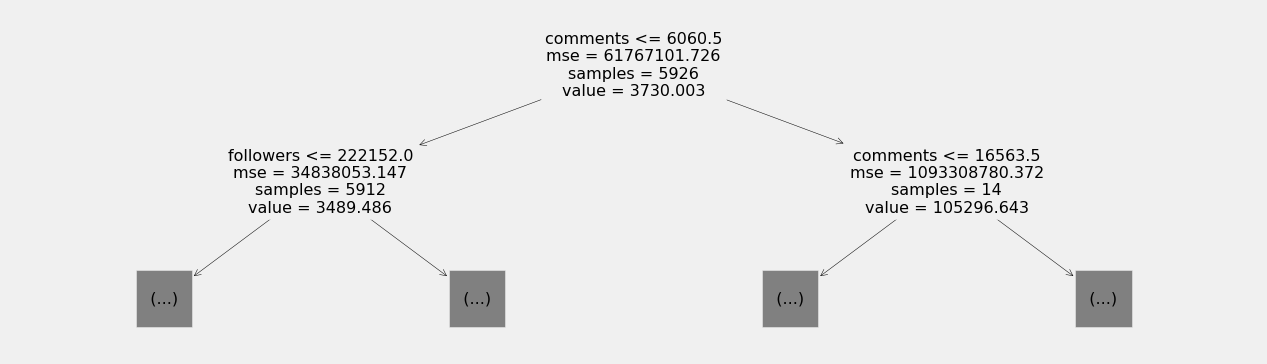

In [488]:
# Displaying the top nodes of the fitted tree model
plt.figure(figsize=(20,6))
sklearn.tree.plot_tree(model_tree, max_depth=1, feature_names=X.columns, fontsize=16)
plt.show()

We see that the top nodes are split using the two highest correlated predictors, comments and followers.

#### Building Regression Forest Model: Initialization and Hyperparameter Tuning

We now initialize and tune the last of the three models, a Regression Forest model. 

In [497]:
# Initializing the Regression Forest Model
reg_forest = RandomForestRegressor(random_state=123)

# Tuning the hyperparameters for the Regression Forest Model
classifier_forest = GridSearchCV(reg_forest,{
    'n_estimators': list(np.arange(97,106,1)),
            }, cv=5)

classifier_forest.fit(X_train, y_train)
results_forest = pd.DataFrame(classifier_forest.cv_results_)
results_forest = results_forest[['params','mean_test_score','rank_test_score']]
top_sorted_results_forest = results_forest.sort_values(by="rank_test_score", axis=0)[0:1]
print(f"The best parameter in the specified range is {classifier_forest.best_params_}")
top_sorted_results_forest

The best parameter in the specified range is {'n_estimators': 101}


,params,mean_test_score,rank_test_score
4,{'n_estimators': 101},0.869073,1


We used `GridSearchCV` to choose the hyperparameter `n_estimators = 101`, which is the number of trees in the forest.

#### Building Regression Forest Model: Evaluating Fitted Model's Predictions for Test Set

We now fit the Regression Forest model with `n_estimators = 101` on the training set and use it to predict on the testing set. 

In [24]:
# Fitting the Regression Tree Model with hyperparameters from tuning
model_forest = RandomForestRegressor(n_estimators=101, criterion="mse",
                              bootstrap=True, random_state=123)
model_forest.fit(X_train, y_train)

# Predicting on test set and obtaining rsquared and RMSE for predictions
test_pred_forest= model_forest.predict(X_test)
rsquare_forest = r2_score(y_test, test_pred_forest)
rmse_forest = mean_squared_error(y_test, test_pred_forest, squared=False)
print("Forest Regressor R-squared score for the test set is", round(rsquare_forest, 5))
print("Forest Regressor RMSE for the test set is", round(rmse_forest, 5))

Forest Regressor rsquared score for test set is 0.9219
Forest Regressor RMSE  for test set is 1991.43612


We evaluated our model's predictive ability by calculating the R-squared and root-mean-square error, which produced $R^{2} = 0.92$ and $RMSE = 1991.44$.

Both of these metrics imply that the Regression Forest model is an improvement upon the previous two models.

#### Visualizing  Feature Importances

We now visualize the ranked feature importances for both the Regression Tree model and the Regression Forest model. 

Feature importance is the average MSE decrease caused by splits on each feature, so larger values indicate more useful predictors. 

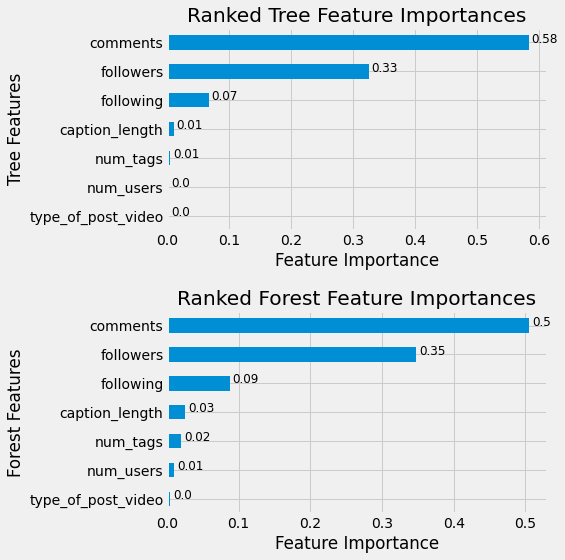

In [492]:
# Creating Series with tree model feature importances
df_for_plot_tree = pd.Series(model_tree.feature_importances_, X.columns)
df_for_plot_tree = df_for_plot_tree.sort_values(axis=0)

# Creating Series with forest model feature importances
df_for_plot_forest = pd.Series(model_forest.feature_importances_, X.columns)
df_for_plot_forest = df_for_plot_forest.sort_values(axis=0)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,8))

# Plotting ranked feature importances for Tree model
df_for_plot_tree.plot(y='feature_importance', kind='barh',
                                          xlabel='Tree Features',
                                          title='Ranked Tree Feature Importances',
                                          figsize=(8,8), ax=axes[0],
                                          legend=False).set_xlabel('Feature Importance')

#Placing value labels on bars
for a, b in enumerate(df_for_plot_tree):
        axes[0].text(b+0.004, a, str(round(b,2)), color='k', fontsize=12)
        
# Plotting ranked feature importances for Forest model
df_for_plot_forest.plot(y='feature_importance', kind='barh',
                                          xlabel='Forest Features',
                                          title='Ranked Forest Feature Importances',
                                          figsize=(8,8), ax=axes[1],
                                          legend=False).set_xlabel('Feature Importance')

# Placing value labels on bars
for aa, bb in enumerate(df_for_plot_forest):
        axes[1].text(bb+0.004, aa, str(round(bb,2)), color='k', fontsize=12)
        
plt.tight_layout()
plt.subplots_adjust(hspace=0.4) 
plt.show()

We see in both models that comments ranks highest, then followers, and then following. The rest of the predictors have fairly small feature importance values.

#### Visualizing Model Evaluation Metrics

We now plot the $R^2$ and $RMSE$ values for each model. 

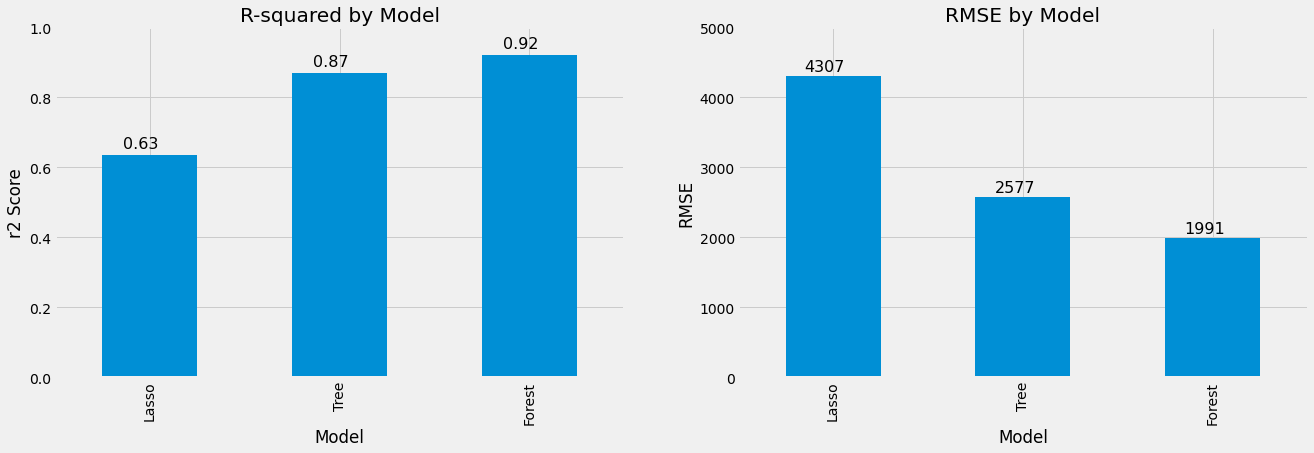

In [501]:
# Creating dataframe with r2 score and rmse for each of the three models
eval_cols = {
    "r2_score":[rsquare_lasso, rsquare_tree, rsquare_forest],
    "rmse": [rmse_lasso, rmse_tree, rmse_forest]
}
evaluation_data = pd.DataFrame(eval_cols, index = ["Lasso", "Tree", "Forest"])

# Plotting the r2 score for each model
plt.subplot(1,2,1)
r2_plot = evaluation_data['r2_score'].plot(kind='bar', xlabel='Model', ylabel='r2 Score',
                                           yticks=list(np.linspace(0,1,6)),
                                           title='R-squared by Model', figsize=(20,6))
# Adding labels to the bars
for a, b in enumerate(evaluation_data['r2_score']):
    plt.text(x=a-0.14, y=b+0.02, s=str(round(b,2)), color='k', fontsize=16)

# Plotting the rmse for each model    
plt.subplot(1,2,2)
rmse_plot = evaluation_data["rmse"].plot(kind="bar", xlabel = 'Model', ylabel = 'RMSE',
                                         yticks=list(np.linspace(0,5000,6)),
                                         title='RMSE by Model', figsize=(20,6))
# Adding labels to the bars
for a, b in enumerate(evaluation_data['rmse']):
    plt.text(x=a-0.15, y=b+65, s=str(np.trunc(b))[:-2], color='k',fontsize=16)
    
plt.subplots_adjust(wspace=0.2) 

The Regression Forest seems to do the best job, as it has the highest $R^2$ and the lowest $RMSE$. 

Next best is the Regression Tree model, and lastly the Lasso Regression model.

#### Visualizing Model Predictions vs Actual Likes

Here we visualize scatterplots of each model's predicted likes vs actual likes. 

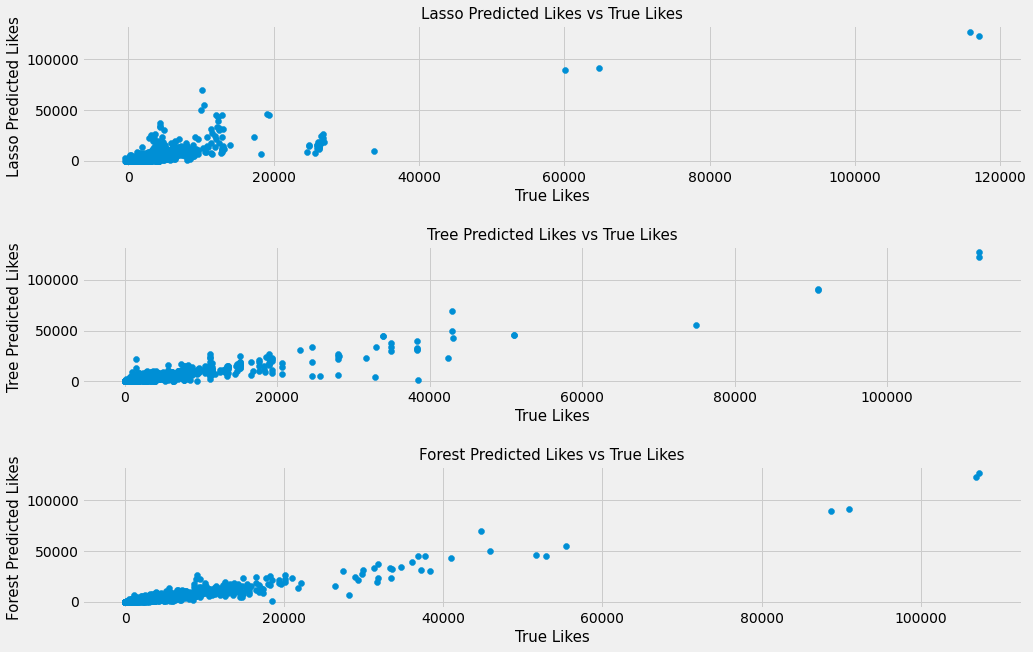

In [502]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))

# Creating Lasso predicted likes vs actual likes scatterplot
axes[0].scatter(test_pred_lasso, y_test)
axes[0].set_xlabel("True Likes", fontsize=15)
axes[0].set_ylabel("Lasso Predicted Likes", fontsize=15)
axes[0].set_title("Lasso Predicted Likes vs True Likes", fontsize=15)

# Creating Tree predicted likes vs actual likes scatterplot
axes[1].scatter(test_pred_tree, y_test)
axes[1].set_xlabel("True Likes", fontsize=15)
axes[1].set_ylabel("Tree Predicted Likes", fontsize=15)
axes[1].set_title("Tree Predicted Likes vs True Likes", fontsize=15)

# Creating Forest predicted likes vs actual likes scatterplot
axes[2].scatter(test_pred_forest, y_test)
axes[2].set_xlabel("True Likes", fontsize=15)
axes[2].set_ylabel("Forest Predicted Likes", fontsize=15)
axes[2].set_title("Forest Predicted Likes vs True Likes", fontsize=15)

plt.tight_layout
plt.subplots_adjust(hspace=0.55)

We hope to have the plotted points close to a regressed diagonal line. 

We see that the Regression Forest model appears to have the lowest variability about the diagonal line, which implies that it is providing the best predictions.

#### Visualizing Model Residuals

We now calculate the residuals for each model by taking the difference between the test set values and the model's predicted values.

We plot each model's residuals against their predicted likes.

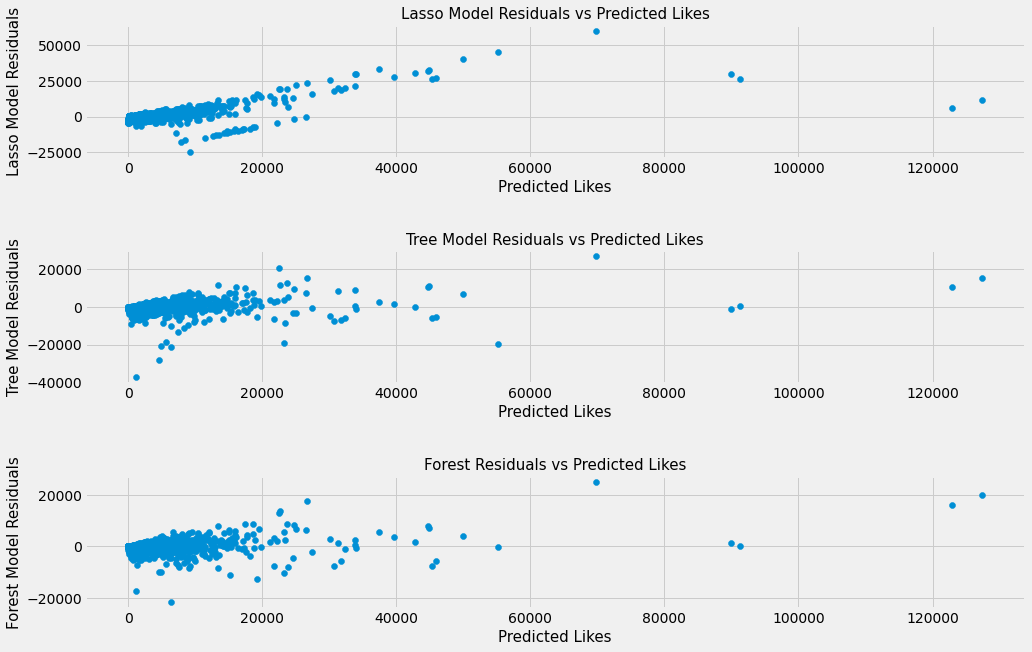

In [468]:
# Calculating residuals for lasso model
residuals_lasso = y_test - test_pred_lasso

# Calculating residuals for tree model
residuals_tree = y_test - test_pred_tree

# Calculating residuals for forest model
residuals_forest = y_test - test_pred_forest

fig, axes = plt.subplots(3, 1, figsize=(15,10))

# Creating Lasso residuals vs predicted likes scatterplot
axes[0].scatter(y_test, residuals_lasso)
axes[0].set_xlabel("Predicted Likes", fontsize=15)
axes[0].set_ylabel("Lasso Model Residuals",fontsize=15)
axes[0].set_title("Lasso Model Residuals vs Predicted Likes", fontsize=15)

# Creating Tree residuals vs predicted likes scatterplot
axes[1].scatter(y_test, residuals_tree)
axes[1].set_xlabel("Predicted Likes", fontsize=15)
axes[1].set_ylabel("Tree Model Residuals",fontsize=15)
axes[1].set_title("Tree Model Residuals vs Predicted Likes", fontsize=15)

# Creating Forest residuals vs predicted likes scatterplot
axes[2].scatter(y_test, residuals_forest)
axes[2].set_xlabel("Predicted Likes", fontsize=15)
axes[2].set_ylabel("Forest Model Residuals", fontsize=15)
axes[2].set_title("Forest Residuals vs Predicted Likes", fontsize=15)

plt.tight_layout
plt.subplots_adjust(hspace=0.70)

 We are hoping for a random dispersion of points around the horizontal axis. 
 
 The plots do a satisfactory job at this, though it seems that the Tree and Forest model are more randomly dispersed than the Lasso Regression model.

#### Conclusion

Based on the three models used to predict the number of likes on an Instagram post, the Random Forest Model is the best in terms of $R^2$ and $RMSE$. 

The two most important features for model predictions were comments and followers.